# Loading the Data

In [1]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [2]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [3]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [4]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Image class: pizza


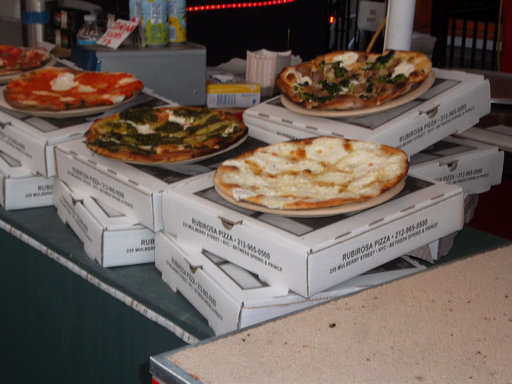

In [5]:
# Visualize an image
from PIL import Image
import random

imgList = list(image_path.glob("*/*/*.jpg"))
randomImg = random.choice(imgList)
label = randomImg.parent.stem
img = Image.open(randomImg)
print(f"Image class: {label}")
img

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [6]:
# 3.1 Transforming data with torchvision.transforms

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [7]:
# Write transform for turning images into tensors
train_transform = transforms.Compose([transforms.Resize(size=(128,128)),
                                      transforms.TrivialAugmentWide(),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(size=(128,128)),
                                      transforms.ToTensor()])

In [8]:
# Write a function to plot transformed images
import matplotlib.pyplot as plt
import numpy as np

def plot_transformed_image(image_path, transform):

  image = Image.open(image_path)
  img_array = np.asarray(image)
  label = image_path.parent.stem
  transformed_img = transform(image).permute(1,2,0)

  fig, ax = plt.subplots(1,2)
  ax[0].imshow(img_array)
  ax[0].set_title(f"Original image of class:{label}")
  ax[0].axis("off")

  ax[1].imshow(transformed_img)
  ax[1].set_title(f"Image transformed")
  ax[1].axis("off")

  fig.suptitle("Orgignal Image vs transformed image ")


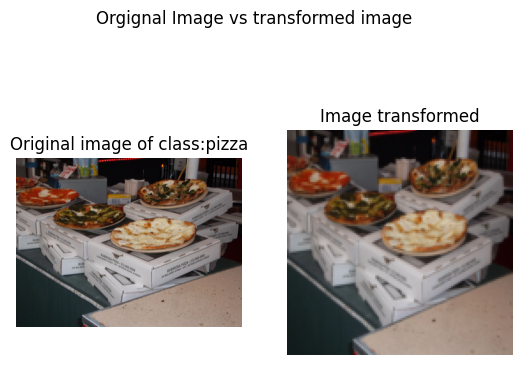

In [9]:
plot_transformed_image(randomImg, train_transform)

### Load image data using `ImageFolder`

In [10]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(train_dir,train_transform)
test_data = datasets.ImageFolder(test_dir, test_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [11]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [12]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [13]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [14]:
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(train_data, batch_size= 32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size= 32, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7abc1b0d58e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7abc1b091ca0>)

In [15]:
# How many batches of images are in our data loaders?
IMAGES, LABELS = next(iter(train_dataloader))

print(IMAGES.shape)

torch.Size([32, 3, 128, 128])


# Building a Model

In [16]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self):
    super().__init__()

    self.convBlock1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size=3, stride = 1, padding = 1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride = 2))

    self.convBlock2 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size=3, padding = 1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels = 10, out_channels=10, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2))

    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=10240, out_features=3))

  def forward(self, x):
    return self.classifier(self.convBlock2(self.convBlock1(x)))



In [17]:
model = TinyVGG()
model

TinyVGG(
  (convBlock1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convBlock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=3, bias=True)
  )
)

In [18]:
# making a prediction
img_batch, label_batch = next(iter(train_dataloader))
img, label = img_batch[0].unsqueeze(dim=0), label_batch[0]

model.eval()
with torch.inference_mode():
  pred = model(img)

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:{label}")

Output logits:
tensor([[-0.0098, -0.0007,  0.0091]])

Output prediction probabilities:
tensor([[0.3302, 0.3332, 0.3365]])

Output prediction label:
tensor([2])

Actual label:2


# Training and Testing

In [19]:
# Check for GPU
!nvidia-smi

Wed Dec 10 14:26:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.9.0+cu126


'cuda'

Epoch [1/50]
  Train Loss: 1.1294, Train Acc: 31.11%
  Test Loss: 1.1471, Test Acc: 25.33%
------------------------------------------------------------
Epoch [2/50]
  Train Loss: 1.1689, Train Acc: 33.33%
  Test Loss: 1.1409, Test Acc: 25.33%
------------------------------------------------------------
Epoch [3/50]
  Train Loss: 1.1185, Train Acc: 29.78%
  Test Loss: 1.0801, Test Acc: 41.33%
------------------------------------------------------------
Epoch [4/50]
  Train Loss: 1.1272, Train Acc: 32.00%
  Test Loss: 1.0778, Test Acc: 41.33%
------------------------------------------------------------
Epoch [5/50]
  Train Loss: 1.0984, Train Acc: 34.22%
  Test Loss: 1.1269, Test Acc: 37.33%
------------------------------------------------------------
Epoch [6/50]
  Train Loss: 1.0934, Train Acc: 38.22%
  Test Loss: 1.1334, Test Acc: 33.33%
------------------------------------------------------------
Epoch [7/50]
  Train Loss: 1.1126, Train Acc: 34.67%
  Test Loss: 1.0971, Test Acc: 33.3

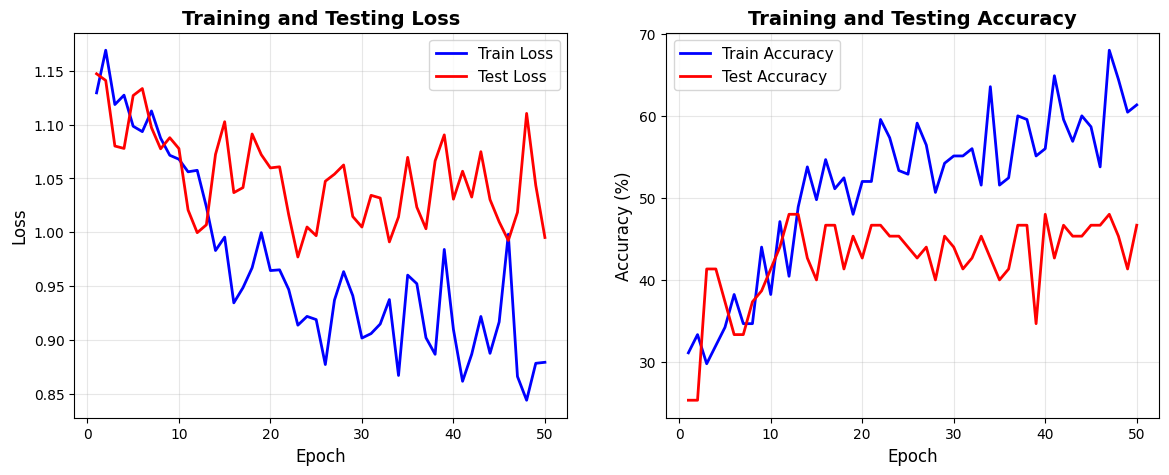

In [21]:
# Storage for results
train_losses = []
train_accs = []
test_losses = []
test_accs = []

lossfun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
EPOCHS = 50

model.to(device)

for epoch in range(EPOCHS):

  model.train()
  train_loss = 0.0
  train_correct = 0
  train_total = 0

  for inputs, labels in train_dataloader:

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    output = model(inputs) # Corrected: passed 'inputs' tensor to the model
    loss = lossfun(output, labels) # Corrected: passed model 'output' and batch 'labels'
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(output.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  train_loss = train_loss / train_total
  train_acc = 100 * train_correct / train_total

  # Testing phase
  test_loss = 0.0
  test_correct = 0
  test_total = 0
  model.eval()
  with torch.inference_mode():
    for inputs, labels in test_dataloader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = lossfun(outputs, labels)

      test_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs.data, 1)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()

  test_loss = test_loss / test_total
  test_acc = 100 * test_correct / test_total

  # Save results
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

  # Print progress
  print(f'Epoch [{epoch+1}/{EPOCHS}]')
  print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
  print(f'  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
  print('-' * 60)


# Plot results
epochs = range(1, EPOCHS + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Testing Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs, train_accs, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs, test_accs, 'r-', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Testing Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

## looks like our model isn't preforming as we hoped, let's try:
* increasing the data
* adding more layers
* changing the transform

### Inreasing the data

In [22]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [23]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Changing the data transforms

In [90]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(train_data_20_percent_path,
                                     train_transform)
test_dataset = datasets.ImageFolder(test_data_20_percent_path,
                                    test_transform)

# Create dataloaders
training_dataloader = DataLoader(train_dataset, 32, shuffle = True)
testing_dataloader = DataLoader(test_dataset, batch_size= 32, shuffle = False)

### increasing model complexity

In [91]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self):
    super().__init__()

    self.convBlock1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size=3, stride = 1, padding = 1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride = 2))

    self.convBlock2 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size=3, padding = 1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels = 10, out_channels=10, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2))

    self.convBlock3 = nn.Sequential(nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size=3, padding = 1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels = 10, out_channels=10, kernel_size=3, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2))

    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=31360, out_features=3))

  def forward(self, x):
    return self.classifier(self.convBlock2(self.convBlock1(x)))



In [92]:
model = TinyVGG().to(device)

Epoch [1/20]
  Train Loss: 1.1002, Train Acc: 40.22%
  Test Loss: 1.0118, Test Acc: 49.33%
------------------------------------------------------------
Epoch [2/20]
  Train Loss: 0.9799, Train Acc: 52.89%
  Test Loss: 0.8769, Test Acc: 58.00%
------------------------------------------------------------
Epoch [3/20]
  Train Loss: 0.9548, Train Acc: 52.89%
  Test Loss: 0.8826, Test Acc: 56.67%
------------------------------------------------------------
Epoch [4/20]
  Train Loss: 0.9028, Train Acc: 59.78%
  Test Loss: 0.8518, Test Acc: 63.33%
------------------------------------------------------------
Epoch [5/20]
  Train Loss: 0.9452, Train Acc: 55.33%
  Test Loss: 0.8352, Test Acc: 64.67%
------------------------------------------------------------
Epoch [6/20]
  Train Loss: 0.8573, Train Acc: 60.89%
  Test Loss: 0.8297, Test Acc: 62.00%
------------------------------------------------------------
Epoch [7/20]
  Train Loss: 0.8716, Train Acc: 59.56%
  Test Loss: 0.8112, Test Acc: 64.6

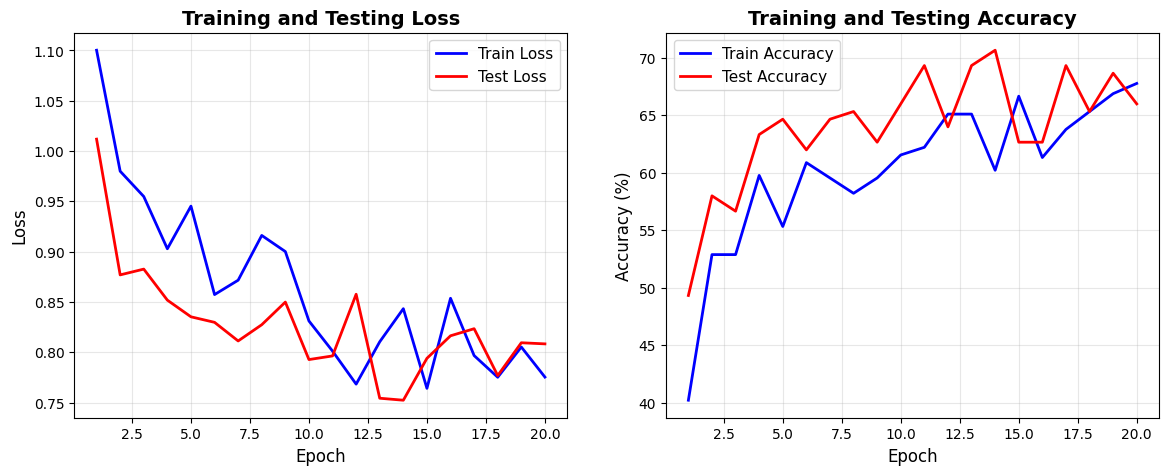

In [93]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Storage for results
train_losses = []
train_accs = []
test_losses = []
test_accs = []

lossfun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
EPOCHS = 20

model.to(device)

for epoch in range(EPOCHS):

  model.train()
  train_loss = 0.0
  train_correct = 0
  train_total = 0

  for inputs, labels in training_dataloader: # Changed to training_dataloader

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    output = model(inputs)
    loss = lossfun(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(output.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  train_loss = train_loss / train_total
  train_acc = 100 * train_correct / train_total

  # Testing phase
  test_loss = 0.0
  test_correct = 0
  test_total = 0
  model.eval()
  with torch.no_grad():
    for inputs, labels in testing_dataloader: # Changed to testing_dataloader
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      loss = lossfun(outputs, labels)

      test_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs.data, 1)
      test_total += labels.size(0)
      test_correct += (predicted == labels).sum().item()

  test_loss = test_loss / test_total
  test_acc = 100 * test_correct / test_total

  # Save results
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

  # Print progress
  print(f'Epoch [{epoch+1}/{EPOCHS}]')
  print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
  print(f'  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
  print('-' * 60)


# Plot results
epochs = range(1, EPOCHS + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Testing Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(epochs, train_accs, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs, test_accs, 'r-', label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Testing Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Making a prediction on a custom image of pizza/steak/sushi (you could even download one from the internet).

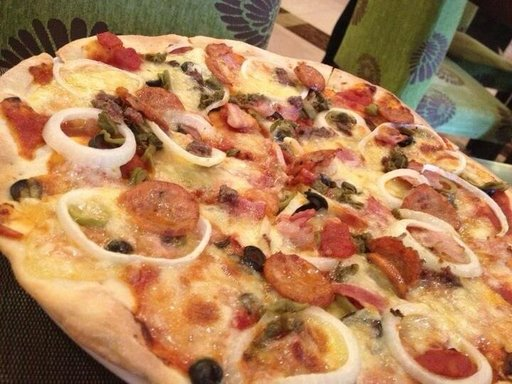

In [85]:
imagePath = "/content/data/pizza_steak_sushi/test/pizza/1503858.jpg"
from PIL import Image
img = Image.open(imagePath)
img

In [86]:
imgTrans = test_transform(img).unsqueeze(dim=1).permute(1,0,2,3)
imgTrans

tensor([[[[-1.0390, -1.0048, -0.8507,  ..., -1.5014, -1.4500, -1.4672],
          [-0.9192, -0.9877, -0.7993,  ..., -1.5014, -1.4500, -1.4672],
          [-0.9877, -0.9705, -0.7822,  ..., -1.4843, -1.4500, -1.4500],
          ...,
          [-1.1589, -1.2103, -1.1932,  ...,  0.1939, -0.0458,  0.0741],
          [-1.1589, -1.0904, -1.2274,  ...,  0.9646,  0.6392,  0.1939],
          [-1.2788, -1.3302, -1.3987,  ...,  1.6667,  1.4783,  0.9817]],

         [[-1.0028, -0.9853, -0.8452,  ..., -1.7206, -1.7206, -1.7731],
          [-0.8627, -0.9503, -0.7752,  ..., -1.7206, -1.7206, -1.7731],
          [-0.8978, -0.9153, -0.7052,  ..., -1.6856, -1.7206, -1.7731],
          ...,
          [-1.3529, -1.4055, -1.3880,  ..., -0.8102, -1.0028, -0.8102],
          [-1.3529, -1.2829, -1.4230,  ..., -0.0224, -0.3200, -0.7052],
          [-1.4755, -1.5280, -1.5980,  ...,  0.6954,  0.5378,  0.1001]],

         [[-1.2990, -1.2990, -1.2293,  ..., -1.5256, -1.5081, -1.5779],
          [-1.1770, -1.2990, -

In [94]:
with torch.inference_mode():
  pred = model(imgTrans.to(device))

In [95]:
proba = torch.softmax(pred, dim = 1)
label = torch.argmax(proba, dim = 1)
print(label)

tensor([0], device='cuda:0')


In [96]:
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}